In [116]:
# Import required libraries

# Data Handling
from __future__ import division
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
import datetime as dt

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode

# Machine Learning
from sklearn import preprocessing as p
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

# Data Access
from google.cloud import bigquery
client = bigquery.Client()
%load_ext google.cloud.bigquery

/Users/gunnar.griese/Desktop/env/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

/Users/gunnar.griese/Desktop/env/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/



The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1. Business Understanding

As a digital analytics enthusiast, it would be quite interesting to apply my data analysis skills here.
<br></br>
My key interests would be:
1. What percentage of users is actually buying and what is there average spend?
2. How are users and revenue distributed geographically?
3. Can the shop's revenue be predicted taking into account historical digital analytics data?
<br></br>

## 2. Data Understanding

In [3]:
#%%bigquery df
# Query the data from BigQuery public dataset

#standardSQL
WITH query_settings AS (
  SELECT
    '20170501' AS start_date,
    '20170801' AS end_date), 

session_level AS (
SELECT 
fullVisitorId, 
CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS session_id,
date,
visitNumber,
visitStartTime,
device.deviceCategory AS device,
geoNetwork.country AS country,
socialEngagementType,
totals.hits AS hits,
totals.pageviews AS pageviews,
IFNULL(totals.timeOnSite, 0) AS time_on_site,
IFNULL(totals.bounces, 0) AS bounces,
IFNULL(totals.transactions, 0) AS transactions,
IFNULL(totals.totalTransactionRevenue, 0) AS revenue,
totals.newVisits AS new_visitor,
totals.sessionQualityDim AS session_quality,
channelgrouping,
trafficSource.medium AS medium,
trafficSource.source AS source
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, query_settings 
WHERE _TABLE_SUFFIX BETWEEN start_date AND end_date),

hit_level AS (
SELECT session_id_p, MAX(landing_page) AS landing_page, MAX(exit_page) AS exit_page
FROM(
SELECT
CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS session_id_p,
FIRST_VALUE(hits.page.pagePath)
    OVER (PARTITION BY CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) ORDER BY hits.time ASC
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS landing_page,
LAST_VALUE(hits.page.pagePath)
    OVER (PARTITION BY CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) ORDER BY hits.time ASC
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS exit_page
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS GA, query_settings, UNNEST(GA.hits) AS hits 
WHERE (_TABLE_SUFFIX BETWEEN start_date AND end_date) AND (hits.type='PAGE'))
GROUP BY 1)

SELECT * EXCEPT(session_id_p)
FROM session_level AS sl
LEFT JOIN hit_level AS hl
ON sl.session_id = hl.session_id_p

SyntaxError: invalid syntax (<ipython-input-3-357053df1b06>, line 5)

In [4]:
# Get the number of sessions.
print("The dataset consists of {} sessions.".format(df.shape[0]))
print("The time period of analysis ranges from {} to {}.".format(df['date'].min(), df['date'].max()))

The dataset consists of 203317 sessions.
The time period of analysis ranges from 20170501 to 20170801.


In [6]:
# Get the data format for each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203317 entries, 0 to 203316
Data columns (total 21 columns):
fullVisitorId           203317 non-null object
session_id              203317 non-null object
date                    203317 non-null object
visitNumber             203317 non-null int64
visitStartTime          203317 non-null int64
device                  203317 non-null object
country                 203317 non-null object
socialEngagementType    203317 non-null object
hits                    203317 non-null int64
pageviews               203286 non-null float64
time_on_site            203317 non-null int64
bounces                 203317 non-null int64
transactions            203317 non-null int64
revenue                 203317 non-null int64
new_visitor             153023 non-null float64
session_quality         68379 non-null float64
channelgrouping         203317 non-null object
medium                  203317 non-null object
source                  203317 non-null object
l

In [7]:
# Show what kind of data is provided
df.columns

Index([u'fullVisitorId', u'session_id', u'date', u'visitNumber',
       u'visitStartTime', u'device', u'country', u'socialEngagementType',
       u'hits', u'pageviews', u'time_on_site', u'bounces', u'transactions',
       u'revenue', u'new_visitor', u'session_quality', u'channelgrouping',
       u'medium', u'source', u'landing_page', u'exit_page'],
      dtype='object')

In [8]:
# Look for missing values
df.isna().sum()

fullVisitorId                0
session_id                   0
date                         0
visitNumber                  0
visitStartTime               0
device                       0
country                      0
socialEngagementType         0
hits                         0
pageviews                   31
time_on_site                 0
bounces                      0
transactions                 0
revenue                      0
new_visitor              50294
session_quality         134938
channelgrouping              0
medium                       0
source                       0
landing_page                31
exit_page                   31
dtype: int64

## 3. Data Preprocessing

#### Pageviews

Rows where 'pageviews' contains NULL values, no landing page exists, but time on site is greater zero, can be considered as "ghost sessions" (sessions without any interaction event). Therefore, these rows are dropped from the further analysis. 

In [9]:
# Drop rows
data = df[df['pageviews'].isnull()==False]

#### Session Quality

An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting. A value of 0 indicates that Session Quality is not calculated for the selected time range. So, if this value is totally missing it's not be being calculated at all. Since more than half of the observations contain NULL values, it seems appropriate to delete the column as a whole.

In [10]:
# Drop column
data.drop(labels='session_quality', axis=1, inplace=True)

/Users/gunnar.griese/Desktop/env/lib/python2.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### New Visitor

BigQuery documentation states: Total number of new users in session (for convenience). If this is the first visit, this value is 1, otherwise it is null. So, NULL values can be easily replaced with 0.

In [11]:
data['new_visitor'].fillna(value=0, inplace = True)

/Users/gunnar.griese/Desktop/env/lib/python2.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## 4. Analysis

## **Question 1: What percentage of users is actually buying and what is the buyers average spend?**

In [12]:
# Reshape data (aggregation)
q1 = data.groupby('fullVisitorId').agg({'session_id': 'count', 'transactions': 'sum', 'revenue': 'sum'}).reset_index()

In [13]:
# Renaming column names
q1.columns = ['fullVisitorId', 'revenue', 'sessions', 'transactions']

In [14]:
# Divide dataset in converters and non-converters
conv = q1[q1['transactions']>0]
non_conv = q1[q1['transactions']<1]

In [15]:
# Percentage of users that are buying
cr = conv.shape[0] / (conv.shape[0] + non_conv.shape[0])
cr_perc = round((cr*100), 2)

print("The percentage of users buying is: {} %".format(cr_perc))

The percentage of users buying is: 1.77 %


In [16]:
# Convert revenue into US-Dollars
# Total transaction revenue, expressed as the value passed to Analytics multiplied by 10^6.
# (e.g., 2.40 would be given as 2400000).
conv['revenue'] = conv['revenue'].apply(lambda x: x/100000)

/Users/gunnar.griese/Desktop/env/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [17]:
print("The buyers average spend is {} $, whereas the median spend is {} $".format(round(conv['revenue'].mean(), 2), conv['revenue'].median()))

The buyers average spend is 1534.23 $, whereas the median spend is 503.8 $


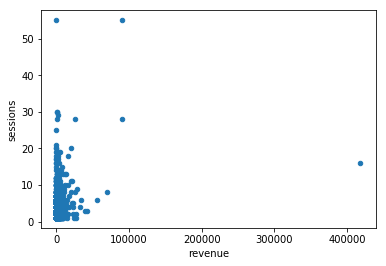

In [18]:
# Create Scatterplot
conv.plot.scatter(x='revenue', y='sessions')

**Summary Q1:**
1. Only 1.77% of the users are buying at all.
2. The buyers average spend is 1534.23 USD, whereas the median spend is 503.8 USD-

## **Q2: How are users and revenue distributed geographically?**

In [19]:
country_lookup = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
country_lookup = country_lookup[['COUNTRY', 'CODE']]

In [34]:
# Reshape data
country_data = data.groupby(['country']).agg({'fullVisitorId': lambda x: x.nunique(), 'revenue': 'sum'}).reset_index()

In [35]:
# Rename columns
country_data.columns = ['country', 'users', 'revenue']

In [36]:
# Calculate revenue per user per country
country_data['revenue'] = country_data['revenue'].apply(lambda x: x/1000000)
country_data['rev_per_user'] = country_data['revenue'] / country_data['users']

In [37]:
country_data.head()

,country,users,revenue,rev_per_user
0,(not set),223,14.29,0.064081
1,Afghanistan,14,0.00,0.000000
2,Albania,32,0.00,0.000000
3,Algeria,177,0.00,0.000000
4,Andorra,2,0.00,0.000000


In [38]:
# Enrich GA data by country code (required for plotting)
raw_plot_data = country_data.merge(country_lookup, how='left', left_on='country', right_on='COUNTRY')

In [39]:
# Exclude countries without country code
plot_data = raw_plot_data[raw_plot_data['CODE'].isna()==False]

In [90]:
# Create interactive plot by utilising plotly
# Resource: https://plot.ly/python/choropleth-maps/

data_vis = [go.Choropleth(
    locations = plot_data['CODE'],
    z = plot_data['rev_per_user'],
    text = plot_data['country'],
    colorscale = [
        [0, "rgb(5, 10, 172)"],
        [0.35, "rgb(40, 60, 190)"],
        [0.5, "rgb(70, 100, 245)"],
        [0.6, "rgb(90, 120, 245)"],
        [0.7, "rgb(106, 137, 247)"],
        [1, "rgb(220, 220, 220)"]
    ],
    autocolorscale = False,
    reversescale = True,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = '$',
        title = 'Revenue per User<br> US$'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'May - June 2017 Google Analytics Public Dataset'
    ),
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Source: <a href="https://support.google.com/analytics/answer/7586738?hl=en">\
            Google Analytics</a>',
        showarrow = False
    )]
)

fig = go.Figure(data = data_vis, layout = layout)
#plotly.offline.init_notebook_mode(connected=False)
plotly.offline.plot(fig, filename = 'ga-world-map.html')

'ga-world-map.html'

In [31]:
plot_data[plot_data['CODE']=='NGA']

,country,users,revenue,rev_per_user,COUNTRY,CODE
134,Nigeria,358,3314.4,9.258101,Nigeria,NGA


Summary Q2:

1. Google Analytics Merchandise Store is most widely accepted in the USA followed by Canada. This was expected.
2. In Nigeria the revenue per user is the highest all over the world. Although total revenue is not even 10% of the US revenue.

## **Q3: Can the shop's revenue be predicted taking into account historical digital analytics data?**

### Data Preparation

In [161]:
# Reshape data
raw_df = data.groupby('date').agg({'fullVisitorId': lambda x: x.nunique(), 'session_id': 'count', 'pageviews': 'sum',
                                'time_on_site': 'mean', 'bounces': 'sum', 'device': lambda x: (x == 'desktop').sum(),
                                'country': lambda x: (x == 'United States').sum(), 'new_visitor': 'sum', 'revenue': 'sum'}).reset_index()

In [162]:
# Inspect resulting dataframe
raw_df.head()

,date,fullVisitorId,pageviews,time_on_site,device,country,new_visitor,revenue,bounces,session_id
0,20170501,2349,10099.0,146.301121,1705,1268,1906.0,7524080000,1239,2587
1,20170502,2340,10550.0,153.340094,1872,1217,1863.0,5695290000,1186,2564
2,20170503,2360,9805.0,150.892968,1897,1166,1922.0,5724060000,1298,2588
3,20170504,2605,9306.0,117.392017,1802,1240,2151.0,3341400000,1583,2806
4,20170505,1769,7612.0,143.989286,1306,935,1408.0,8054000000,969,1960


In [163]:
# Rename columns
raw_df.columns = ['date', 'total_users', 'total_pageviews', 'avg_timeonsite', 'desktop_share',
                  'us_share', 'new_visitors_share','total_revenue', 'bounces_share', 'total_sessions']

In [164]:
# Scale data for modeling

# Create a copy of the dataframe
scaled_features = raw_df.copy()

# Apply scaler to time periods between page views
col_names = ['total_users', 'total_pageviews', 'avg_timeonsite',
             'desktop_share', 'us_share', 'new_visitors_share',
             'bounces_share', 'total_sessions'
            ]
features = scaled_features[col_names]
scaler = p.MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

# Re-assign columns
scaled_features[col_names] = features

raw_df = scaled_features

In [165]:
# Exclude peak days from training
#raw_df = raw_df[raw_df['date']!='20170713']
#raw_df = raw_df[raw_df['date']!='20170718']

In [166]:
# Separate features and target
y = raw_df['total_revenue']
X = raw_df.drop('total_revenue', axis=1)

In [167]:
# Create train and test datasets
y_train = raw_df['total_revenue'][0:60]
X_train = raw_df[0:60].drop('total_revenue', axis=1)
y_test = raw_df['total_revenue'][60:]
X_test = raw_df[60:].drop('total_revenue', axis=1)

### Modelling

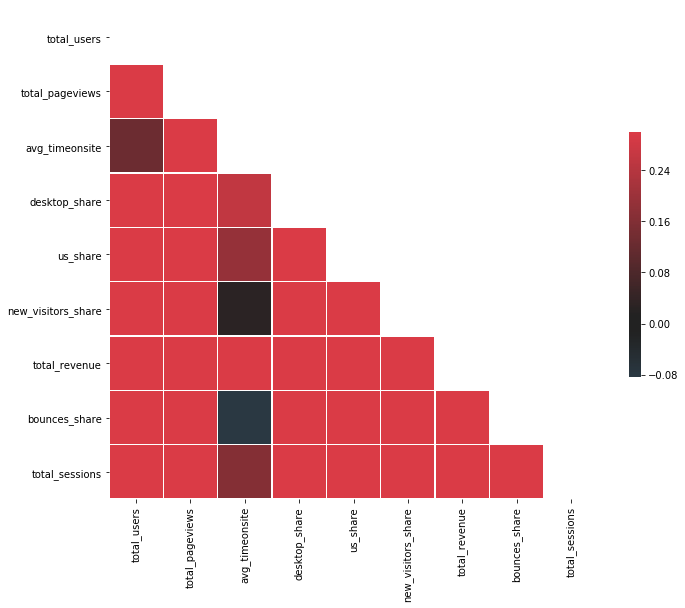

In [196]:
# CHECK FOR MULTICOLLINEARITY
df_corr = raw_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=30, center="dark", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Linear Regression

In [180]:
regressor = LinearRegression()
lm = regressor.fit(X_train,y_train)

In [181]:
lm_pred = lm.predict(X_test)
print(r2_score(y_test, lm_pred))
print(mean_squared_error(y_test, lm_pred))

0.2789457298380851
5.294483395607199e+18


### Random Forest

In [182]:
rf = RandomForestRegressor(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(r2_score(y_test, rf_pred))
print(mean_squared_error(y_test, rf_pred))

0.3903636315711768
4.4763754457481887e+18


### AdaBoost 

In [183]:
AdaRegressor = AdaBoostRegressor(n_estimators=500, random_state=0)
AdaRegressor.fit(X_train, y_train)
ada_pred = AdaRegressor.predict(X_test)
print(r2_score(y_test, ada_pred))
print(mean_squared_error(y_test, ada_pred))

0.25455809512329164
5.473554420353524e+18


### Evaluation

In [174]:
# Compare R2 scores for each regressor
predictions = [lm_pred, rf_pred, ada_pred]
r2_scores = []

for i in predictions:
    r2_scores.append(r2_score(y_test, i))

Text(0.5,1,'R2-Scores for Regressors')

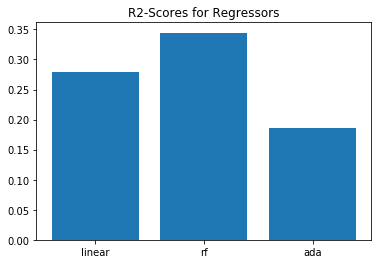

In [175]:
plt.bar(x = ['linear', 'rf', 'ada'], height = r2_scores)
plt.title("R2-Scores for Regressors")

Text(0.5,1,'Feature Importance')

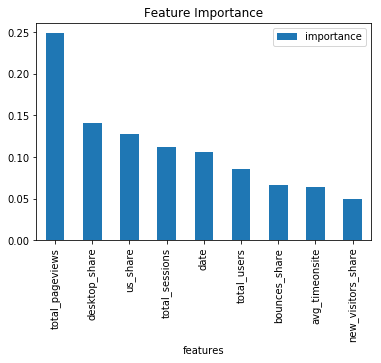

In [199]:
feat_imp = pd.DataFrame()

feat_imp['features'] = X_train.columns
feat_imp['importance'] = rf.feature_importances_
feat_imp.sort_values('importance', ascending=False).plot.bar(x='features')
plt.title('Feature Importance')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 <a list of 31 Text xticklabel objects>)

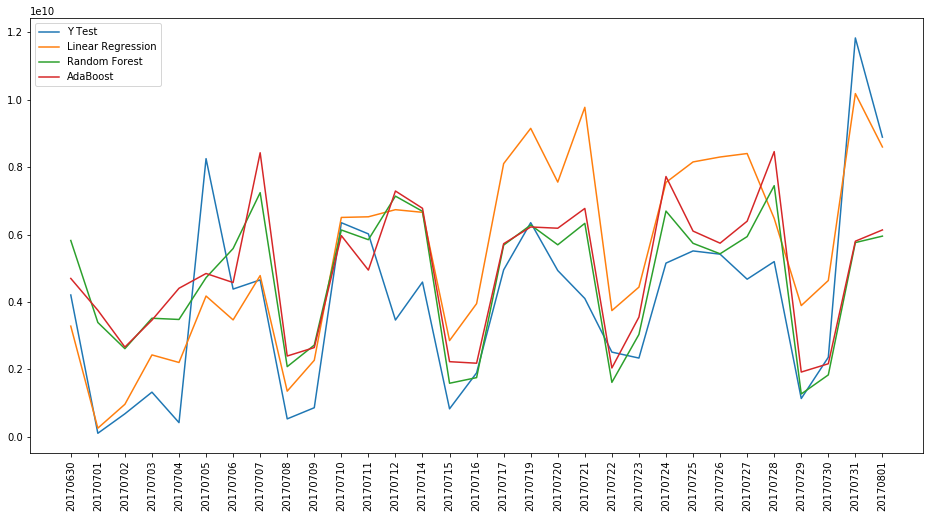

In [206]:
# Plot predictions
fig = plt.figure(figsize=(16,8))

plt.plot(raw_df['date'][60:].to_numpy(), y_test,
         raw_df['date'][60:].to_numpy(), lm_pred,
        raw_df['date'][60:].to_numpy(), rf_pred,
         raw_df['date'][60:].to_numpy(), ada_pred
        )
# TO DO: Define nice colors
# ax.set_prop_cycle(['red', 'black', 'yellow', 'green'])
plt.legend(['Y Test', 'Linear Regression', 'Random Forest', 'AdaBoost'])
plt.xticks(rotation=90)